<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/GDSTK_Spiral_Resonators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below are some spiral resonator layouts

In [ ]:
pip install gdstk matplotlib

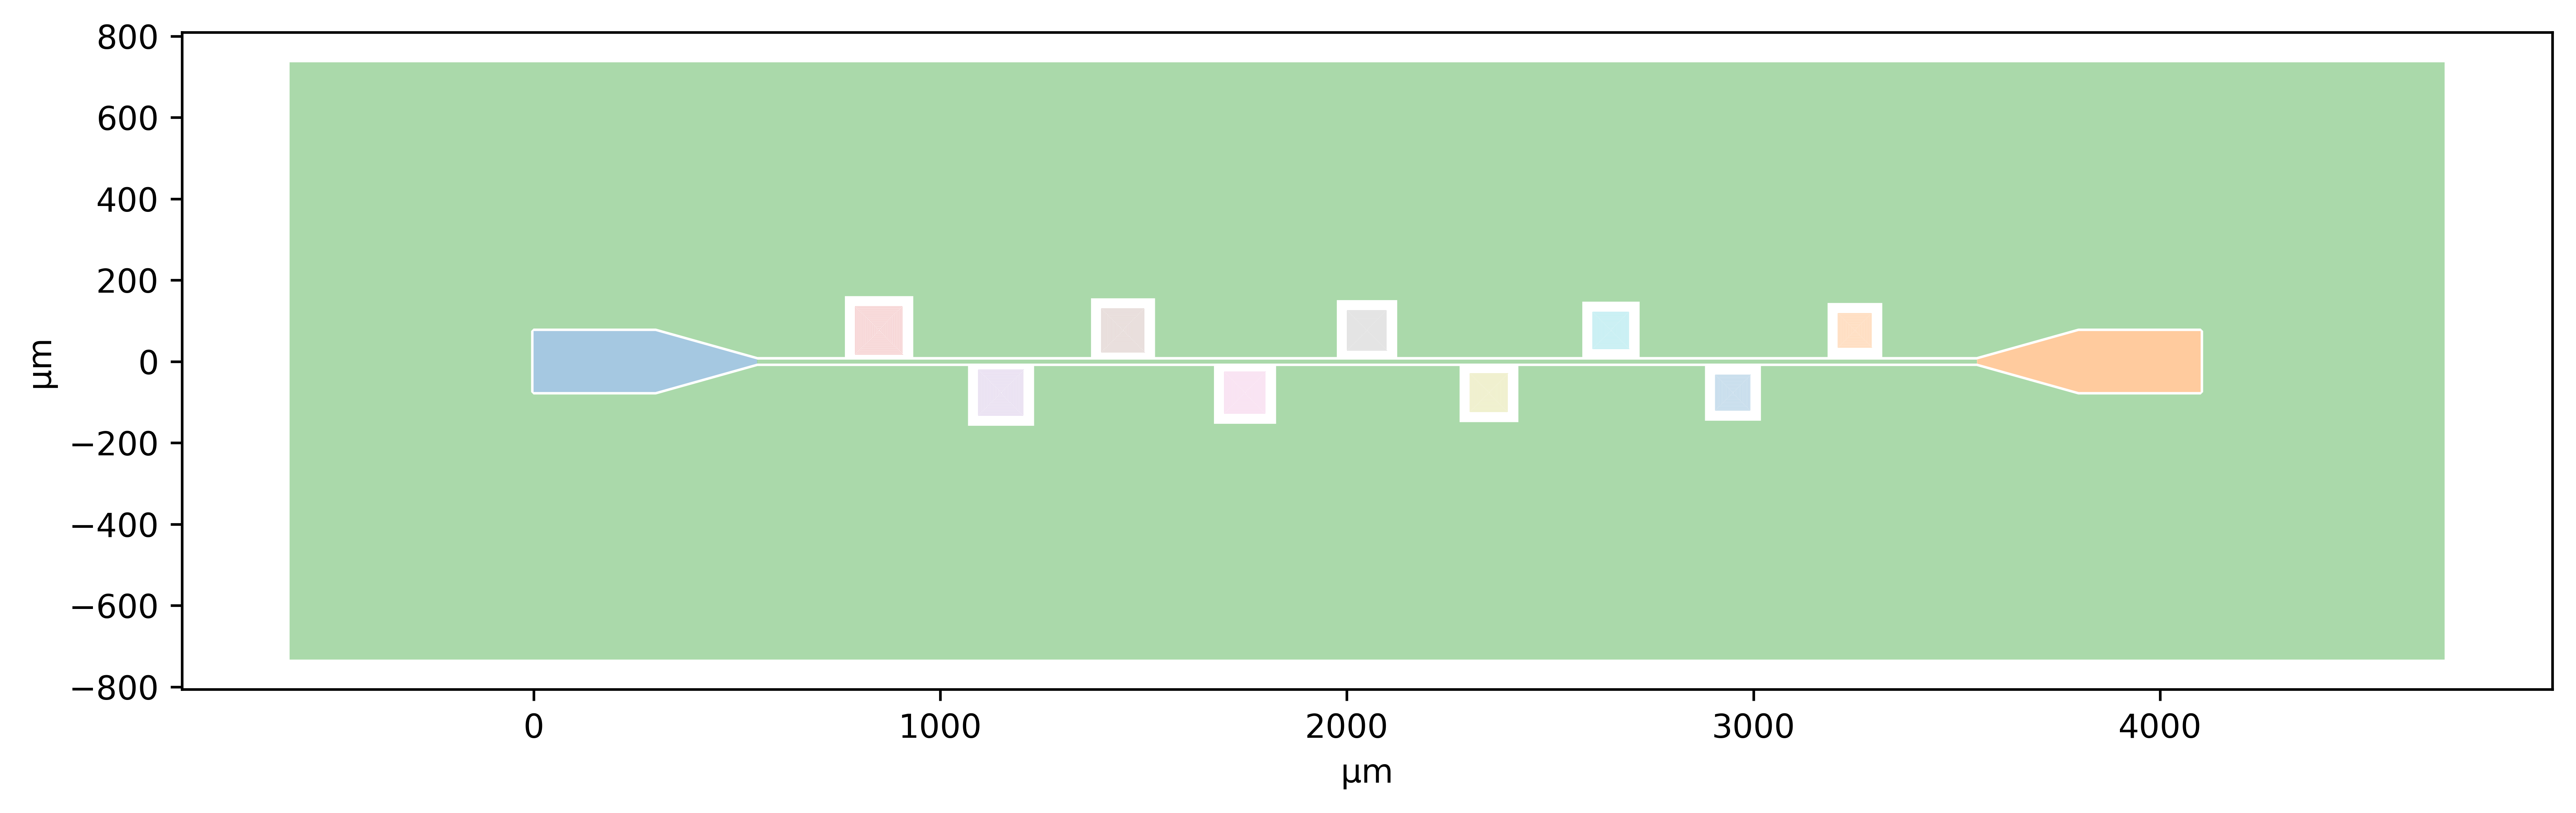


OASIS written to cpw_greekkey_resonators_control_knobs.oas



In [35]:
#!/usr/bin/env python3
"""
CPW Feed with Rotated Greek-Key–Fractal λ/4 Metamaterial Resonators
(no IDCs) — Resonators placed with adjustable spacing and count

Author   : Onri Jay Benally / Modified with Greek-Key control knobs
Date     : 2025-06-06
───────────────────────────────────────────
Run locally or in Colab:

    pip install gdstk matplotlib
    python cpw_greekkey_resonators_control_knobs.py

Outputs:
    • Interactive preview window (Matplotlib)
    • cpw_greekkey_resonators_control_knobs.oas   (OASIS-v1.0 layout)
"""
# ───────────────────────────────────
# 0) Imports & Matplotlib style
# ───────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

# ───────────────────────────────────
# Control Knobs: Adjust these values to change fractal behavior
# ───────────────────────────────────
# Number of Greek-key loops (higher → more complex square spiral)
GK_ITER = 50                  # integer: 1, 2, 3, …
# Fraction of step length used as bend radius in FlexPath (0 → sharp corners, up to 0.5 or more)
FRACTAL_FILLET_FACTOR = 0.3   # float: 0.0 to 1.0 (or higher for smoother arcs)
# Vertical spacing (gap) between CPW feed and resonator (controls stagger spacing)
FRACTAL_SPACING = 65.0        # µm   baseline gap from feed conductor to fractal anchor
# Horizontal spacing between adjacent fractals (center-to-center)
FRACTAL_HORZ_SPACING = 300.0  # µm   horizontal pitch between resonators
# Number of resonators to place
NUM_RESONATORS = 9            # integer: how many staggered fractals
# Frequency range for resonators (GHz)
FREQ_MIN = 5.0                # GHz   lowest resonance
FREQ_MAX = 7.0                # GHz   highest resonance

# ───────────────────────────────────
# 1) Technology & Electrical Design Parameters
# ───────────────────────────────────
tech = dict(
    # — CPW feed line (feed_len computed based on FRACTAL_HORZ_SPACING and NUM_RESONATORS) —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=None,             # µm   placeholder; auto-calculated later

    # — Greek-key–fractal resonators —
    w_res=1.0,                 # µm   resonator trace width
    g_res=2.0,                 # µm   keep-out gap (unused)
    gk_iter=GK_ITER,           # loops for Greek-key spiral
    fractal_fillet_factor=FRACTAL_FILLET_FACTOR,  # bend radius factor
    fractal_spacing=FRACTAL_SPACING,  # µm   vertical spacing from CPW feed
    fractal_horz_spacing=FRACTAL_HORZ_SPACING,  # µm   horizontal spacing
    d_feed_res=2.0,            # µm   (unused)

    # — Square cavity margin —
    sq_margin=40.0,            # µm   margin around each fractal for square cavity
    fillet_radius=15.0,        # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=300.0,        # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths based on chosen frequency range and number of resonators
LQ_5GHZ = 6000.0  # µm quarter-wave at 5 GHz in this substrate
freqs = np.linspace(FREQ_MIN, FREQ_MAX, NUM_RESONATORS)  # GHz array of resonant frequencies
lambda_quarters = LQ_5GHZ * FREQ_MIN / freqs  # µm per resonator for λ/4 scaling

# ───────────────────────────────────
# 2) Build the Greek-key spiral unit polyline (no truncation)
# ───────────────────────────────────
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def greek_key_polyline(n: int) -> np.ndarray:
    """Generate a square-spiral (Greek-key) unit-step polyline for n loops."""
    pts = [np.array([0.0, 0.0])]
    cur_dir = 0
    # lengths: 1,1,2,2,3,3,... up to 2n
    lengths = []
    for i in range(1, n + 1):
        lengths.extend([i, i])
    for length in lengths:
        for _ in range(length):
            pts.append(pts[-1] + _DIRECTIONS[cur_dir])
        cur_dir = (cur_dir + 1) % 4
    return np.asarray(pts)

# Compute the unit-step polyline for the chosen number of loops
_UNIT_POLYLINE = greek_key_polyline(tech["gk_iter"])
_NUM_MOVES = len(_UNIT_POLYLINE) - 1
_UNIT_WIDTH = _UNIT_POLYLINE[:, 0].max() - _UNIT_POLYLINE[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES  # dimensionless

# ───────────────────────────────────
# 3) Helper: quick preview
# ───────────────────────────────────

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────
# 4) Geometry utilities
# ───────────────────────────────────

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    """Linear taper from feed width to pad width followed by rectangular pad."""
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

# ───────────────────────────────────
# 5) Build one Greek-key–fractal resonator (rotated left 90°)
# ───────────────────────────────────

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    """Rotate points left (CCW) by 90° about origin."""
    return np.column_stack((-pts[:, 1], pts[:, 0]))


def build_greekkey_resonator(origin, lambda_q, p, upward=True):
    """
    Return a list of polygons for one Greek-key spiral resonator (rotated left 90°).
    """
    step = lambda_q / _NUM_MOVES
    pts = _UNIT_POLYLINE * step
    pts = rotate_left_90(pts)
    if not upward:
        pts = pts.copy()
        pts[:, 1] *= -1
    pts += np.asarray(origin) - pts[0]
    # use control knob for bend radius
    bend_radius = step * p.get("fractal_fillet_factor", 0.5)
    fp = gdstk.FlexPath(
        pts.tolist(), p["w_res"], bend_radius=bend_radius, simple_path=True
    )
    return fp.to_polygons()

# ───────────────────────────────────
# 6) Assemble the full chip with large filleted square cavities
# ───────────────────────────────────

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    # Compute feed_len based on horizontal spacing and number of resonators
    num_res = NUM_RESONATORS
    inset = p.get("fractal_horz_spacing", 0.0)
    total_res_width = (num_res - 1) * p.get("fractal_horz_spacing", 0.0)
    p["feed_len"] = 2 * inset + total_res_width

    # Pads + feed line using updated feed_len
    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    # Position each resonator using horizontal spacing
    start_x = feed_x0 + inset
    for idx in range(num_res):
        lambda_q = lambda_quarters[idx]
        upward = (idx % 2 == 0)
        anchor_x = start_x + idx * p.get("fractal_horz_spacing", 0.0)
        # Vertical offset from control knob
        y_off = p["w_feed"]/2 + p["g_feed"] + p.get("fractal_spacing", 70.0) + p["w_res"]/2
        anchor_y = y_off if upward else -y_off

        # Build fractal
        res_polys = build_greekkey_resonator((anchor_x, anchor_y), lambda_q, p, upward)
        cell.add(*res_polys)
        conductors.extend(res_polys)

        # Compute union and create square cavity
        res_union = gdstk.boolean(res_polys, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    # Autocarved ground plane
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    # Frame
    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"],
                 xs_all.max() + p["margin"], ys_all.max() + p["margin"] )
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

# ───────────────────────────────────
# 7) Main
# ───────────────────────────────────
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_greekkey_resonators_control_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")


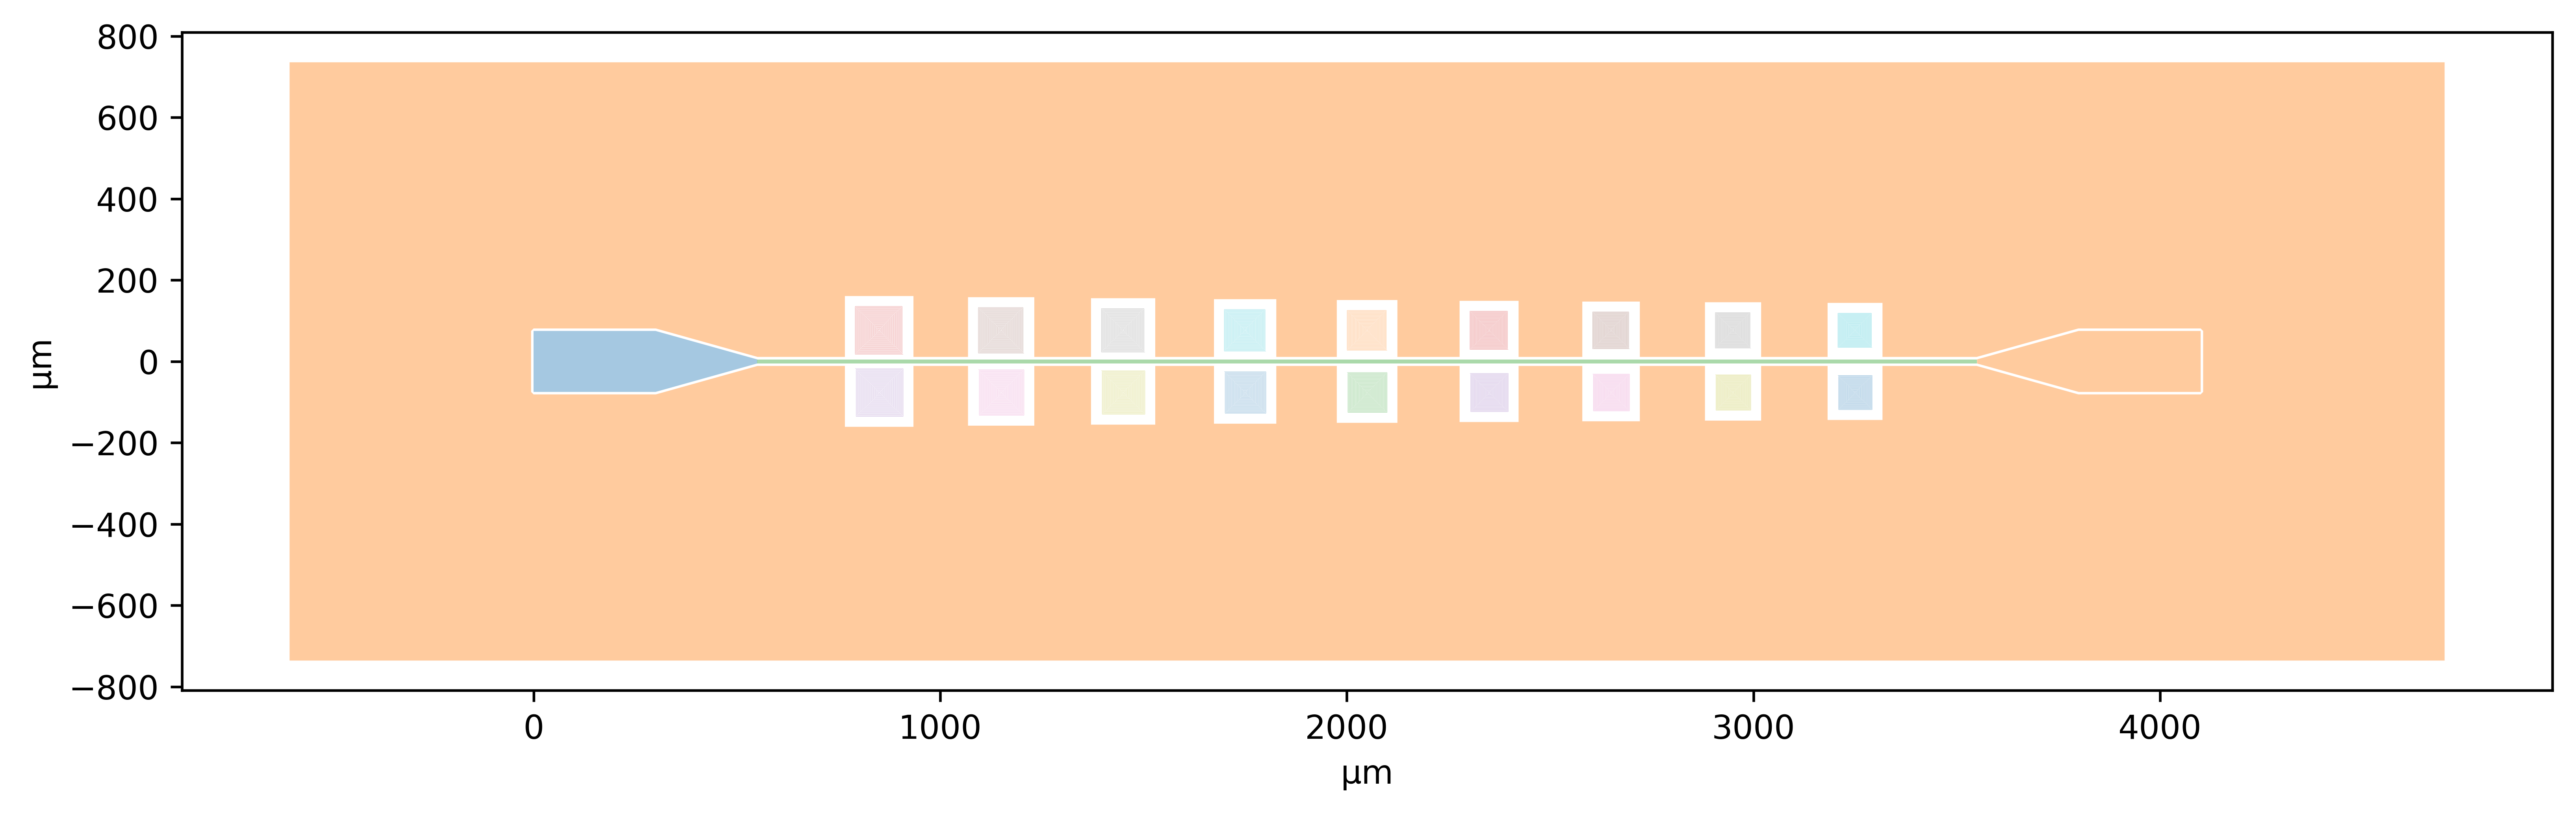


OASIS written to cpw_greekkey_separated_spirals_control_knobs.oas



In [38]:
#!/usr/bin/env python3
"""
CPW Feed with Separated Double-Spiral Greek-Key–Fractal λ/4 Metamaterial Resonators
(no IDCs) — Two spirals placed adjacent above and below CPW feedline

Author   : Onri Jay Benally / Modified for separated spirals
Date     : 2025-06-06
───────────────────────────────────────────
Run locally or in Colab:

    pip install gdstk matplotlib
    python cpw_greekkey_separated_spirals_control_knobs.py

Outputs:
    • Interactive preview window (Matplotlib)
    • cpw_greekkey_separated_spirals_control_knobs.oas   (OASIS-v1.0 layout)
"""
# ───────────────────────────────────
# 0) Imports & Matplotlib style
# ───────────────────────────────────
import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams["figure.dpi"] = 600

# ───────────────────────────────────
# Control Knobs: Adjust these values to change fractal behavior
# ───────────────────────────────────
# Number of Greek-key loops for each spiral (higher → more complex square spiral)
GK_ITER = 50                  # integer: 1, 2, 3, …
# Fraction of step length used as bend radius in FlexPath (0 → sharp corners, up to 0.5 or more)
FRACTAL_FILLET_FACTOR = 0.3   # float: 0.0 to 1.0 (or higher for smoother arcs)
# Vertical spacing (gap) from CPW feed to spiral (controls how far spirals sit)
FRACTAL_SPACING = 65.0        # µm   baseline gap from feed conductor to spiral anchor
# Horizontal spacing between adjacent spiral pairs (center-to-center)
FRACTAL_HORZ_SPACING = 300.0  # µm   horizontal pitch between resonator pairs
# Number of resonator pairs to place (each pair has one above and one below)
NUM_RESONATORS = 9            # integer: how many pairs
# Frequency range for resonators (GHz)
FREQ_MIN = 5.0                # GHz   lowest resonance
FREQ_MAX = 7.0                # GHz   highest resonance

# ───────────────────────────────────
# 1) Technology & Electrical Design Parameters
# ───────────────────────────────────
tech = dict(
    # — CPW feed line (feed_len computed based on FRACTAL_HORZ_SPACING and NUM_RESONATORS) —
    w_feed=10.0,               # µm   centre-conductor width
    g_feed=6.0,                # µm   gap to ground
    feed_len=None,             # µm   placeholder; auto-calculated later

    # — Greek-key–fractal resonators —
    w_res=1.0,                 # µm   resonator trace width
    g_res=2.0,                 # µm   keep-out gap (unused)
    gk_iter=GK_ITER,           # loops for Greek-key spiral
    fractal_fillet_factor=FRACTAL_FILLET_FACTOR,  # bend radius factor
    fractal_spacing=FRACTAL_SPACING,  # µm   vertical spacing from feed
    fractal_horz_spacing=FRACTAL_HORZ_SPACING,  # µm   horizontal spacing
    d_feed_res=2.0,            # µm   (unused)

    # — Square cavity margin —
    sq_margin=40.0,            # µm   margin around each spiral for square cavity
    fillet_radius=15.0,        # µm   radius for filleted cavity corners

    # — Cavity & chip frame —
    cavity_margin=300.0,       # µm   clearance around each resonator for precise cavity
    margin=600.0,              # µm   ground-to-edge clearance

    # — Launch pads (rectangular pad + linear taper) —
    pad_len=300.0,             # µm   pad length
    pad_wid=150.0,             # µm   pad width
    pad_taper_len=250.0,       # µm   taper length (w_feed → pad_wid)
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])

# λ/4 electrical lengths based on chosen frequency range and number of resonators
LQ_5GHZ = 6000.0  # µm quarter-wave at 5 GHz in this substrate
freqs = np.linspace(FREQ_MIN, FREQ_MAX, NUM_RESONATORS)  # GHz array of resonant frequencies
lambda_quarters = LQ_5GHZ * FREQ_MIN / freqs  # µm per resonator for λ/4 scaling

# ───────────────────────────────────
# 2) Build the Greek-key spiral unit polyline (no truncation)
# ───────────────────────────────────
_DIRECTIONS = (
    np.array([1, 0]),   # →
    np.array([0, 1]),   # ↑
    np.array([-1, 0]),  # ←
    np.array([0, -1]),  # ↓
)

def greek_key_polyline(n: int) -> np.ndarray:
    """Generate a square-spiral (Greek-key) unit-step polyline for n loops."""
    pts = [np.array([0.0, 0.0])]
    cur_dir = 0
    # lengths: 1,1,2,2,3,3,... up to 2n
    lengths = []
    for i in range(1, n + 1):
        lengths.extend([i, i])
    for length in lengths:
        for _ in range(length):
            pts.append(pts[-1] + _DIRECTIONS[cur_dir])
        cur_dir = (cur_dir + 1) % 4
    return np.asarray(pts)

# Compute the unit-step polyline for the chosen number of loops
_UNIT_POLYLINE = greek_key_polyline(tech["gk_iter"])
_NUM_MOVES = len(_UNIT_POLYLINE) - 1
_UNIT_WIDTH = _UNIT_POLYLINE[:, 0].max() - _UNIT_POLYLINE[:, 0].min()
_BOUND_RATIO = _UNIT_WIDTH / _NUM_MOVES  # dimensionless

# ───────────────────────────────────
# 3) Helper: quick preview
# ───────────────────────────────────

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    try:
        cell.plot(ax)
    except AttributeError:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.25)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# ───────────────────────────────────
# 4) Geometry utilities
# ───────────────────────────────────

def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_launch_pad(origin_x: float, y0: float, direction: int, p: dict) -> gdstk.Polygon:
    """Linear taper from feed width to pad width followed by rectangular pad."""
    w1, w2 = p["w_feed"], p["pad_wid"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]
    x_feed = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end = x_taper_end + direction * pad_len
    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)

# ───────────────────────────────────
# 5) Build one Greek-key–fractal spiral resonator
# ───────────────────────────────────

def rotate_left_90(pts: np.ndarray) -> np.ndarray:
    """Rotate points left (CCW) by 90° about origin."""
    return np.column_stack((-pts[:, 1], pts[:, 0]))


def rotate_right_90(pts: np.ndarray) -> np.ndarray:
    """Rotate points right (CW) by 90° about origin."""
    return np.column_stack((pts[:, 1], -pts[:, 0]))


def build_greekkey_resonator(origin, lambda_q, p, upward=True):
    """
    Return a list of polygons for one Greek-key spiral resonator (rotated left or right 90°).
    """
    step = lambda_q / _NUM_MOVES
    pts = _UNIT_POLYLINE * step
    if upward:
        pts = rotate_left_90(pts)
    else:
        pts = rotate_right_90(pts)
    pts += np.asarray(origin) - pts[0]
    bend_radius = step * p.get("fractal_fillet_factor", 0.5)
    fp = gdstk.FlexPath(pts.tolist(), p["w_res"], bend_radius=bend_radius, simple_path=True)
    return fp.to_polygons()

# ───────────────────────────────────
# 6) Assemble the full chip with large filleted square cavities
# ───────────────────────────────────

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []
    cavities = []

    # Compute feed_len based on horizontal spacing and number of resonators
    num_res = NUM_RESONATORS
    inset = p.get("fractal_horz_spacing", 0.0)
    total_res_width = (num_res - 1) * p.get("fractal_horz_spacing", 0.0)
    p["feed_len"] = 2 * inset + total_res_width

    # Pads + feed line using updated feed_len
    feed_x0 = p["pad_len"] + p["pad_taper_len"]
    pad_left = build_launch_pad(feed_x0, 0.0, -1, p)
    pad_right = build_launch_pad(feed_x0 + p["feed_len"], 0.0, +1, p)
    feed_line = build_straight_cpw((feed_x0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(pad_left, pad_right, *feed_line)
    conductors.extend([pad_left, pad_right, *feed_line])

    # Position each pair of spirals: one above and one below the CPW feed
    start_x = feed_x0 + inset
    # Compute vertical offset for spirals to sit adjacent (not overlapping) to feed line
    y_off = p["w_feed"]/2 + p["g_feed"] + p.get("fractal_spacing", 70.0) + p["w_res"]/2
    for idx in range(num_res):
        lambda_q = lambda_quarters[idx]
        anchor_x = start_x + idx * p.get("fractal_horz_spacing", 0.0)

        # Build upper spiral
        origin_top = (anchor_x, y_off)
        res_polys_top = build_greekkey_resonator(origin_top, lambda_q, p, upward=True)
        cell.add(*res_polys_top)
        conductors.extend(res_polys_top)

        # Build lower spiral
        origin_bot = (anchor_x, -y_off)
        res_polys_bot = build_greekkey_resonator(origin_bot, lambda_q, p, upward=False)
        cell.add(*res_polys_bot)
        conductors.extend(res_polys_bot)

        # Compute union of both spirals for one cavity
        res_union = gdstk.boolean(res_polys_top + res_polys_bot, [], "or")
        xs = np.concatenate([poly.points[:, 0] for poly in res_union])
        ys = np.concatenate([poly.points[:, 1] for poly in res_union])
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        sq_min_x = min_x - p["sq_margin"]
        sq_min_y = min_y - p["sq_margin"]
        sq_max_x = max_x + p["sq_margin"]
        sq_max_y = max_y + p["sq_margin"]
        sq_rect = gdstk.rectangle((sq_min_x, sq_min_y), (sq_max_x, sq_max_y))
        filleted_sq = gdstk.offset(sq_rect, -p["fillet_radius"], join="round")
        cavities.extend(filleted_sq)

    # Autocarved ground plane
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout_candidate = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")
    keepout = []
    if keepout_candidate:
        try:
            keepout = gdstk.boolean(keepout_candidate + cavities, [], "or")
        except Exception:
            keepout = []

    # Frame
    xs_all = np.concatenate([poly.points[:, 0] for poly in conductors])
    ys_all = np.concatenate([poly.points[:, 1] for poly in conductors])
    frame = rect(xs_all.min() - p["margin"], ys_all.min() - p["margin"],
                 xs_all.max() + p["margin"], ys_all.max() + p["margin"] )
    if keepout:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                ground = gdstk.boolean(frame, keepout, "not")
            cell.add(*ground)
        except Exception:
            cell.add(frame)
    else:
        cell.add(frame)

    return lib

# ───────────────────────────────────
# 7) Main
# ───────────────────────────────────
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top, figsize=(11, 4))

    out_file = "cpw_greekkey_separated_spirals_control_knobs.oas"
    lib.write_oas(out_file)
    print(f"\nOASIS written to {out_file}\n")